# 1.) Suppose that we design a deep architecture to represent a sequence by stacking self-attention layers with positional encoding. What could be issues? (paragraph format)


**<u>Answer:</u>**

One possible issue with stacking self-attention layers with positional encoding is that the model may not be able to capture the long-term dependencies and structural information of the input sequence. This is because the positional encoding only provides a fixed representation of the relative or absolute positions of the words, which may not be sufficient to model the complex syntactic and semantic relationships among them. Self-attention mechanisms are permutation invariant meaning that they do not inherently respect the order of elements in a sequence.


To address this issue, some researchers have proposed to augment self-attention layers with structural position representations, which can encode the latent structure of the input sentence, such as the dependency tree or the constituency tree. For example, Wang et al. [1] proposed to use dependency tree to represent the grammatical structure of a sentence, and introduced two strategies to encode the positional relationships among words in the dependency tree. They showed that their approach improved the performance of neural machine translation over both the absolute and relative sequential position representations.


Another possible issue with stacking self-attention layers with positional encoding is that the model may suffer from overfitting or underfitting due to the large number of parameters and the lack of regularization. Stacking several self-attention layers to construct a deeper network can lead to over-smoothing of tokens leading distinct tokens to become quite similar in nature. If tokens become too similar, this will weaken the model’s ability to distinguish between different positions in a sequence. Hence, the model’s comprehension of syntactic and grammatical structure are both tarnished with this type of structural difference in the architecture. Self-attention laters are also fully connected by desgin in order to attend to any pair of words in a sequence which can lead to overfitting on smaller datasets.


To address this issue, some researchers have proposed the use of convolutional layers or recurrent layers in conjunction with self-attention layers, which can provide local or sequential information and reduce the number of parameters. For example, Shen et al. [2] proposed using convolutional self-attention networks, which combine convolutional layers and self-attention layers in a hierarchical structure. They showed that their approach achieved state-of-the-art results on various NLP tasks, such as text classification, natural language inference, and machine translation.


[1] [1909.00383] Self-Attention with Structural Position .... https://arxiv.org/abs/1909.00383.

[2] undefined. https://doi.org/10.48550/arXiv.1909.00383.


#2.) Can you design a learnable positional encoding method using pytorch? (Create dummy dataset)

Dataset Creation: Even or Odd Classification of the Sum of Integer Sequences (Binary Classification Task)

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# === Toy Dataset ===
# Binary classification dataset of sequences of 10 integers from 0-19.
# Classify sums of sequences as either even or odd
class SequenceDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=10, vocab_size=20):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.data = torch.randint(0, vocab_size, (num_samples, seq_len))
        self.labels = (self.data.sum(dim=1) % 2)  # Binary classification based on sequence sum

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class AugmentedSequenceDataset(SequenceDataset):
    def __init__(self, num_samples, seq_len, vocab_size, mask_prob=0.1):
        super().__init__(num_samples, seq_len, vocab_size)
        self.mask_prob = mask_prob

    def __getitem__(self, idx):
        sequence, label = super().__getitem__(idx)
        sequence = sequence.clone()  # Avoid modifying the original
        mask = torch.rand(sequence.size()) < self.mask_prob
        sequence[mask] = self.vocab_size  # Assign special token for masked positions
        return sequence, label


def display_dataset(dataset, num_samples=5):
    """
    Display a few samples from the dataset.

    Args:
        dataset (Dataset): The dataset to visualize.
        num_samples (int): The number of samples to display.
    """
    num_samples = min(num_samples, len(dataset))
    fig, axes = plt.subplots(num_samples, 1, figsize=(8, num_samples * 2))
    if num_samples == 1:
        axes = [axes]  # Ensure axes is iterable for a single sample

    for i in range(num_samples):
        data, label = dataset[i]
        axes[i].bar(range(len(data)), data, color='blue', alpha=0.6)
        axes[i].set_title(f"Sample {i + 1}: Label = {label}")
        axes[i].set_xlabel("Sequence Index")
        axes[i].set_ylabel("Token Value")
        axes[i].set_xticks(range(len(data)))

    plt.tight_layout()
    plt.show()

def print_example_sequences(dataset, num_samples=5):
    """
    Print example sequences and their corresponding labels from the dataset.

    Args:
        dataset (Dataset): The dataset object.
        num_samples (int): Number of sequences to print.
    """
    num_samples = min(num_samples, len(dataset))
    print(f"Displaying {num_samples} sequences from the dataset:\n")

    for i in range(num_samples):
        sequence, label = dataset[i]
        print(f"Sample {i + 1}:")
        print(f"Sequence: {sequence.tolist()}")
        print(f"Label: {label.item()}")
        print("-" * 40)


dataset = SequenceDataset(num_samples=10, seq_len=10, vocab_size=20)
print_example_sequences(dataset, num_samples=5)

Displaying 5 sequences from the dataset:

Sample 1:
Sequence: [6, 9, 1, 10, 4, 15, 6, 13, 18, 15]
Label: 1
----------------------------------------
Sample 2:
Sequence: [14, 19, 18, 2, 0, 9, 1, 18, 14, 2]
Label: 1
----------------------------------------
Sample 3:
Sequence: [17, 2, 4, 16, 15, 7, 1, 13, 4, 19]
Label: 0
----------------------------------------
Sample 4:
Sequence: [2, 8, 8, 18, 19, 15, 13, 0, 12, 13]
Label: 0
----------------------------------------
Sample 5:
Sequence: [8, 18, 4, 0, 11, 1, 17, 8, 0, 1]
Label: 0
----------------------------------------


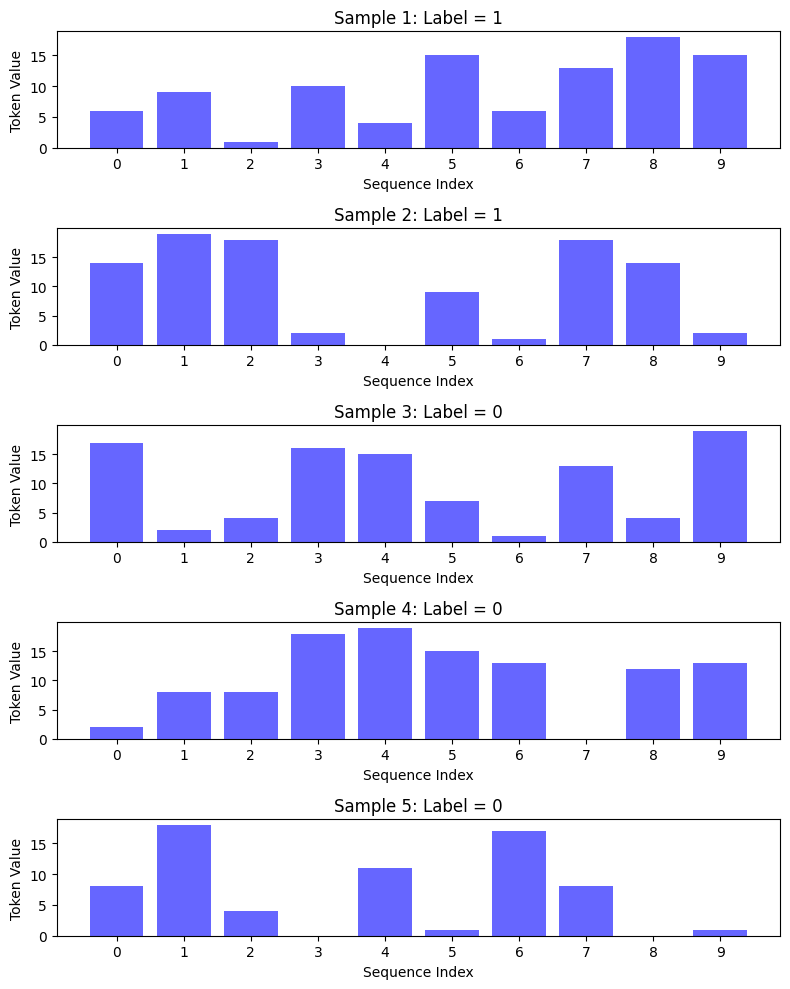

In [47]:
display_dataset(dataset, num_samples=5)

## **Approach:**

**1.) <u>Initialize Learnable Embeddings:</u>**

Define a positional embedding matrix $P$ where each position in a matrix $P_{i}$ has a corresponding embedding: $P = {P_1 , P_2 ,...,P_L},$ where     $P_{i}∈ \mathbb{R}^d$


Here $L$ is the max sequence length (max_length) and $d$ is the embedding dimension (d_model). These embeddings are intialized randomly and learned during training.


**2.) <u>Combine Embeddings with Token Embeddings:</u>**

For each token $x_{i}$ in the sequence, add it's positional embedding $P_{i}$ to it's token embedding $E_{i}$

$H^{(0)}_{i}$ $= E_{i} + P_{i}$ where $H^{(0)}_{i}$ becomes the input into the first self-attention layer


**3.) <u>Scalable Coding for Variable Length Sequences:</u>**

To handle sequences longer than max length $L$, we can interpolate the positional embedding matrix $P$ using a continuous function to generate embeddings for positions beyond $L$.


**4.) <u>Attention-aware Positional Encoding:</u>**

To make positional encodings adapt dynamically within each self-attention layer we can combine learnable encodings with attention mechanisms:

$P^{(l)}_{i}$ $= MLP(P^{(l-1)}_{i} ​+ Self Attention(P^{(l−1)}))$

**5.) <u>Relative Positional Encoding:</u>**

To represent relative distances between tokens (instead of absolute positions), define embeddings for relative positions $r = i - j$

$P_{ij} = Embedding(i - j)$


In [48]:
# === Learnable Positional Encoding ===
# === Scalable, Attention-Aware, and Relative Positional Encoding ===
class LearnablePositionalEncoding(nn.Module):
   def __init__(self, max_len, d_model, n_heads):
        super().__init__()
        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.position_embeddings = nn.Embedding(max_len, d_model)
        self.self_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, batch_first=True)
        self.relative_positions = nn.Embedding(2 * max_len - 1, d_model)

   def interpolate_positional_encoding(self, seq_len):
        """
        Handle sequences longer than max_len using interpolation.
        """
        original_positions = torch.arange(0, self.max_len, device=self.position_embeddings.weight.device).float()
        interpolated_positions = torch.linspace(0, self.max_len - 1, seq_len, device=self.position_embeddings.weight.device)
        interpolated_weights = torch.nn.functional.interpolate(
            self.position_embeddings.weight.unsqueeze(0),
            size=(seq_len, self.d_model),
            mode='linear',
            align_corners=False,
        )[0]
        return interpolated_weights

   def compute_relative_positions(self, seq_len):
        """
        Generate relative positional embeddings for a sequence of length seq_len.
        """
        position_ids = torch.arange(seq_len, device=self.relative_positions.weight.device)
        relative_position_ids = position_ids[None, :] - position_ids[:, None] + (self.max_len - 1)
        return self.relative_positions(relative_position_ids)  # Shape: (seq_len, seq_len, d_model)

   def forward(self, x):
        """
        x: (batch_size, seq_len)
        """
        seq_len = x.size(1)
        batch_size = x.size(0)

        # Positional embeddings
        if seq_len > self.max_len:
            pos_embeds = self.interpolate_positional_encoding(seq_len)
        else:
            positions = torch.arange(0, seq_len, device=x.device)
            pos_embeds = self.position_embeddings(positions)

        # Apply self-attention to refine positional embeddings
        pos_embeds = pos_embeds.unsqueeze(0).expand(batch_size, -1, -1)  # (batch_size, seq_len, d_model)
        refined_pos_embeds, _ = self.self_attention(pos_embeds, pos_embeds, pos_embeds)  # (batch_size, seq_len, d_model)

        # Return refined embeddings without directly adding relative positional embeddings
        return refined_pos_embeds

   def add_relative_positional_scores(self, attention_scores, seq_len):
        """
        Add relative positional embeddings directly to the attention scores.
        """
        relative_pos_embeds = self.compute_relative_positions(seq_len)  # Shape: (seq_len, seq_len, d_model)
        relative_scores = torch.einsum('bqd,qkd->bqk', attention_scores, relative_pos_embeds)
        return attention_scores + relative_scores

# === Transformer-Based Model ===
class TransformerSequenceClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, max_len, num_classes):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = LearnablePositionalEncoding(max_len, d_model, n_heads)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=256),
            num_layers=n_layers
        )
        self.fc = nn.Linear(d_model, num_classes)
        # self.fc = nn.Sequential(
        #     nn.Dropout(dropout),  # Dropout before classification
        #     nn.Linear(d_model, num_classes)
        # )

    def forward(self, x):

        # x: (batch_size, seq_len)
        seq_len = x.size(1)
        token_embeds = self.token_embeddings(x)  # Shape: (batch_size, seq_len, d_model)
        pos_embeds = self.positional_encoding(x)  # Shape: (batch_size, seq_len, d_model)
        embeddings = token_embeds + pos_embeds  # Combine token and positional embeddings

        # Transformer encoder
        transformer_output = self.transformer(embeddings)  # Shape: (batch_size, seq_len, d_model)

        # Classification head (use first token's representation)
        cls_output = transformer_output[:, 0, :]  # Take the representation of the first token
        logits = self.fc(cls_output)  # Shape: (batch_size, num_classes)
        return logits



In [49]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def split_dataset(dataset, test_size=0.2):
    """
    Split the dataset into training and testing subsets.

    Args:
        dataset (Dataset): The dataset to split.
        test_size (float): Proportion of the dataset to use as the test set.

    Returns:
        train_dataset (Subset): The training subset.
        test_dataset (Subset): The testing subset.
    """
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    return train_dataset, test_dataset

def evaluate_model(model, dataloader):
    """
    Evaluate the model on a test dataset.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for the test dataset.

    Returns:
        float: Test accuracy.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

# === Main Training and Evaluation ===
def train_and_evaluate():
    # Hyperparameters
    vocab_size = 20
    d_model = 64
    max_len = 10
    n_heads = 4
    n_layers = 2
    num_classes = 2
    batch_size = 32
    num_epochs = 10
    learning_rate = 1e-3

    # Dataset and Train-Test Split
    dataset = SequenceDataset(num_samples=1000, seq_len=max_len, vocab_size=vocab_size)
    augmented_dataset = AugmentedSequenceDataset(num_samples=1000, seq_len=max_len, vocab_size=vocab_size, mask_prob=0.1)
    train_dataset, test_dataset = split_dataset(dataset, test_size=0.2)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, Loss, Optimizer
    model = TransformerSequenceClassifier(vocab_size, d_model, n_heads, n_layers, max_len, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

    # Evaluate on Test Dataset
    test_accuracy = evaluate_model(model, test_loader)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


train_and_evaluate()

Epoch 1/10, Loss: 0.7438
Epoch 2/10, Loss: 0.6947
Epoch 3/10, Loss: 0.6847
Epoch 4/10, Loss: 0.6877
Epoch 5/10, Loss: 0.6864
Epoch 6/10, Loss: 0.6919
Epoch 7/10, Loss: 0.6844
Epoch 8/10, Loss: 0.6820
Epoch 9/10, Loss: 0.6867
Epoch 10/10, Loss: 0.6824
Test Accuracy: 44.00%
